# RL Training Evaluation Visualization

This notebook visualizes training evaluation logs saved in an `evaluations.npz` file produced by `EvalCallback` (or custom callbacks)

### Configuration

In [13]:
import os
import json
import numpy as np
from pathlib import Path

LATEST = '/Users/jinceyang/Desktop/codebase/nuscourse/nus_ceg_homework/ceg5306/pa3/gym-pybullet-drones/results/best-5/evaluations.npz'
print(f'Using evaluation file: {LATEST}')

data = np.load(LATEST, allow_pickle=True)
print('Keys in file:', list(data.keys()))

timesteps = data['timesteps']
results = data['results']  # shape: (N, n_eval_episodes)
if 'ep_lengths' in data:
    ep_lengths = data['ep_lengths']
else:
    ep_lengths = None

print(f'Num eval rounds: {len(timesteps)}  | Episodes per eval: {results.shape[1]}')
print('First 5 timesteps:', timesteps[:5])
print('Last 5 timesteps:', timesteps[-5:])

Using evaluation file: /Users/jinceyang/Desktop/codebase/nuscourse/nus_ceg_homework/ceg5306/pa3/gym-pybullet-drones/results/best-5/evaluations.npz
Keys in file: ['timesteps', 'results', 'ep_lengths']
Num eval rounds: 940  | Episodes per eval: 5
First 5 timesteps: [1000 2000 3000 4000 5000]
Last 5 timesteps: [936000 937000 938000 939000 940000]


### Metric computation

In [14]:
import pandas as pd

mean_return = results.mean(axis=1)
std_return = results.std(axis=1)

if ep_lengths is not None:
    mean_ep_len = ep_lengths.mean(axis=1)
    std_ep_len = ep_lengths.std(axis=1)
    return_per_step = mean_return / mean_ep_len
else:
    mean_ep_len = np.full_like(mean_return, np.nan)
    std_ep_len = np.full_like(mean_return, np.nan)
    return_per_step = np.full_like(mean_return, np.nan)

# Global threshold success heuristic (percentile over all episodes)
flat_returns = results.flatten()
percentile_threshold = 70
success_threshold_global = np.percentile(flat_returns, percentile_threshold)
success_rate_global = (results > success_threshold_global).mean(axis=1)

# Adaptive (per-eval) threshold (not comparable across evals, but shows internal skew)
success_threshold_adaptive = np.percentile(results, percentile_threshold, axis=1, keepdims=True)
success_rate_adaptive = (results > success_threshold_adaptive).mean(axis=1)

# Best mean_return index
best_idx = mean_return.argmax()
# Also best efficiency index
best_eff_idx = (~np.isnan(return_per_step) * (return_per_step == np.nanmax(return_per_step))).argmax()

summary = {
    'eval_rounds': len(mean_return),
    'episodes_per_eval': results.shape[1],
    'best_mean_return': float(mean_return[best_idx]),
    'best_mean_return_timestep': int(timesteps[best_idx]),
    'best_efficiency_return_per_step': float(return_per_step[best_eff_idx]) if not np.isnan(return_per_step[best_eff_idx]) else None,
    'best_efficiency_timestep': int(timesteps[best_eff_idx]) if not np.isnan(return_per_step[best_eff_idx]) else None,
    'global_success_threshold': float(success_threshold_global)
}
print(json.dumps(summary, indent=2))

{
  "eval_rounds": 940,
  "episodes_per_eval": 5,
  "best_mean_return": 418.3008006,
  "best_mean_return_timestep": 897000,
  "best_efficiency_return_per_step": 1.7285157049586777,
  "best_efficiency_timestep": 897000,
  "global_success_threshold": 398.4618391
}


### Plot: mean return curve

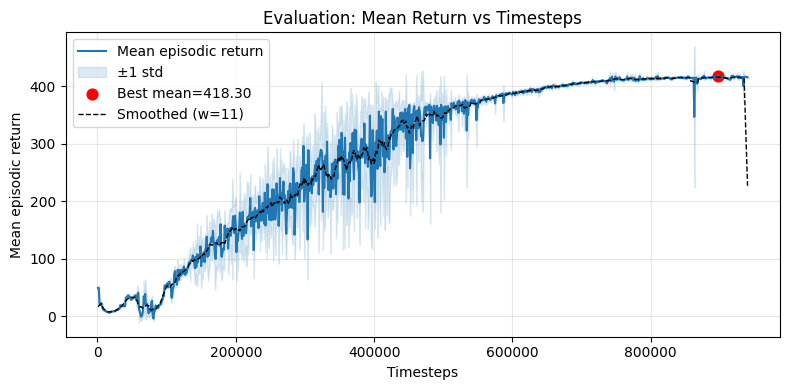

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(timesteps, mean_return, label='Mean episodic return', color='tab:blue')
plt.fill_between(timesteps, mean_return-std_return, mean_return+std_return, color='tab:blue', alpha=0.15, label='±1 std')
plt.scatter([timesteps[best_idx]],[mean_return[best_idx]],color='red',s=60,label=f'Best mean={mean_return[best_idx]:.2f}')

# Optional smoothing (simple moving average)
if len(mean_return) > 5:
    window = min(11, len(mean_return)//2*2+1)  # odd window
    smooth = np.convolve(mean_return, np.ones(window)/window, mode='same')
    plt.plot(timesteps, smooth, color='black', linestyle='--', linewidth=1, label=f'Smoothed (w={window})')

plt.xlabel('Timesteps')
plt.ylabel('Mean episodic return')
plt.title('Evaluation: Mean Return vs Timesteps')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Plot: episode length & efficiency

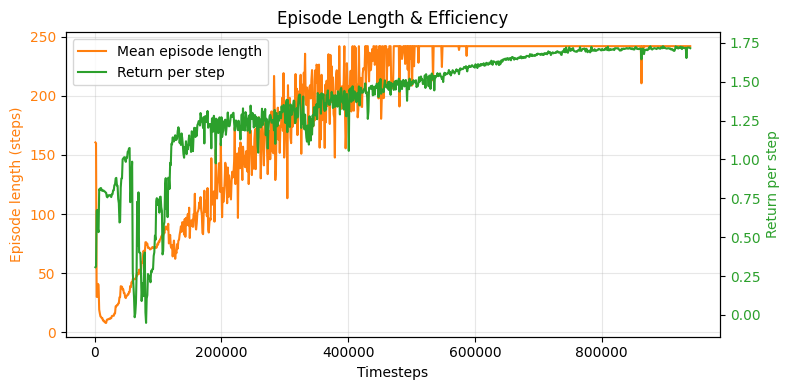

In [16]:
if ep_lengths is not None:
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(timesteps, mean_ep_len, color='tab:orange', label='Mean episode length')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Episode length (steps)', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(timesteps, return_per_step, color='tab:green', label='Return per step')
    ax2.set_ylabel('Return per step', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Combine legends
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')
    plt.title('Episode Length & Efficiency')
    plt.tight_layout()
    plt.show()
else:
    print('ep_lengths not available: cannot compute efficiency plot.')

### Tabular summary

In [ ]:
import pandas as pd

rows = []
for i, t in enumerate(timesteps):
    row = {
        'timestep': int(t),
        'mean_return': float(mean_return[i]),
        'std_return': float(std_return[i]),
    }
    if ep_lengths is not None:
        row['mean_ep_len'] = float(mean_ep_len[i])
        row['return_per_step'] = float(return_per_step[i])
    if 'global_success_rate_history' in globals():
        row['global_success_rate'] = float(global_success_rate_history[i])
        row['adaptive_success_rate'] = float(adaptive_success_rate_history[i])
    rows.append(row)

df = pd.DataFrame(rows)
display(df.head())
print(f'Total evaluation points: {len(df)}')

EXPORT_CSV = True 
if EXPORT_CSV:
    out_path = 'results/best-5/evaluation_metrics.csv'
    df.to_csv(out_path, index=False)
    print('Saved metrics to', out_path)

,timestep,mean_return,std_return,mean_ep_len,return_per_step
0,1000,49.311179,0.729908,160.6,0.307043
1,2000,49.805191,0.000000,160.0,0.311282
2,3000,20.104636,0.411806,30.0,0.670155
3,4000,20.274353,0.000336,30.0,0.675812
4,5000,22.676924,6.080945,41.0,0.553096


Total evaluation points: 940
Saved metrics to results/evaluation_metrics.csv
